### 1. Install Dependencies and Setup

In [29]:
import os
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

### 2. Cleaning the dataset (removing corrupted images)

In [ ]:
from PIL import Image
import os

def clean_jpeg_images(data_dir):
    """
    Processes all images in the dataset, detects and fixes issues such as
    corrupt images or incorrect metadata. If an image cannot be fixed, it is removed.
    
    Args:
        data_dir (str): Path to the dataset containing subdirectories for each class.
    """
    for image_class in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, image_class)
        for image in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image)
            try:
                # Open the image to validate its integrity
                with Image.open(image_path) as img:
                    img = img.convert("RGB")  # Convert to RGB format for consistency
                    img.save(image_path, "JPEG")  # Re-save the image to fix potential issues
                    print(f"Image fixed: {image_path}")
            except Exception as e:
                # Remove the image if it is corrupted or cannot be fixed
                print(f"Error processing image {image_path}: {e}")
                os.remove(image_path)

data_dir = "/Users/r1/Documents/Projets_python/IA/Cat_Dog_Binary_Classification/Dataset"

# Clean the dataset by fixing or removing problematic images
clean_jpeg_images(data_dir)


Image corrigée : /Users/r1/Documents/Projets_python/IA/Cat_Dog_Binary_Classification/Dataset/Cat/9733.jpg
Image corrigée : /Users/r1/Documents/Projets_python/IA/Cat_Dog_Binary_Classification/Dataset/Cat/63.jpg
Image corrigée : /Users/r1/Documents/Projets_python/IA/Cat_Dog_Binary_Classification/Dataset/Cat/6400.jpg
Image corrigée : /Users/r1/Documents/Projets_python/IA/Cat_Dog_Binary_Classification/Dataset/Cat/823.jpg
Image corrigée : /Users/r1/Documents/Projets_python/IA/Cat_Dog_Binary_Classification/Dataset/Cat/4217.jpg
Image corrigée : /Users/r1/Documents/Projets_python/IA/Cat_Dog_Binary_Classification/Dataset/Cat/3578.jpg
Image corrigée : /Users/r1/Documents/Projets_python/IA/Cat_Dog_Binary_Classification/Dataset/Cat/2666.jpg
Image corrigée : /Users/r1/Documents/Projets_python/IA/Cat_Dog_Binary_Classification/Dataset/Cat/5109.jpg
Image corrigée : /Users/r1/Documents/Projets_python/IA/Cat_Dog_Binary_Classification/Dataset/Cat/2100.jpg
Image corrigée : /Users/r1/Documents/Projets_pyth

In [34]:
#Count the number of images in each class
from collections import Counter

dataset_path = "/Users/r1/Documents/Projets_python/IA/Cat_Dog_Binary_Classification/Dataset"
class_counts = Counter()

for root, dirs, files in os.walk(dataset_path):
    for dir in dirs:
        class_path = os.path.join(root, dir)
        class_counts[dir] += len(os.listdir(class_path))

print(class_counts)

Counter({'Cat': 9979, 'Dog': 9979})


### 3. Load Data and Preprocessing

Found 19958 files belonging to 2 classes.


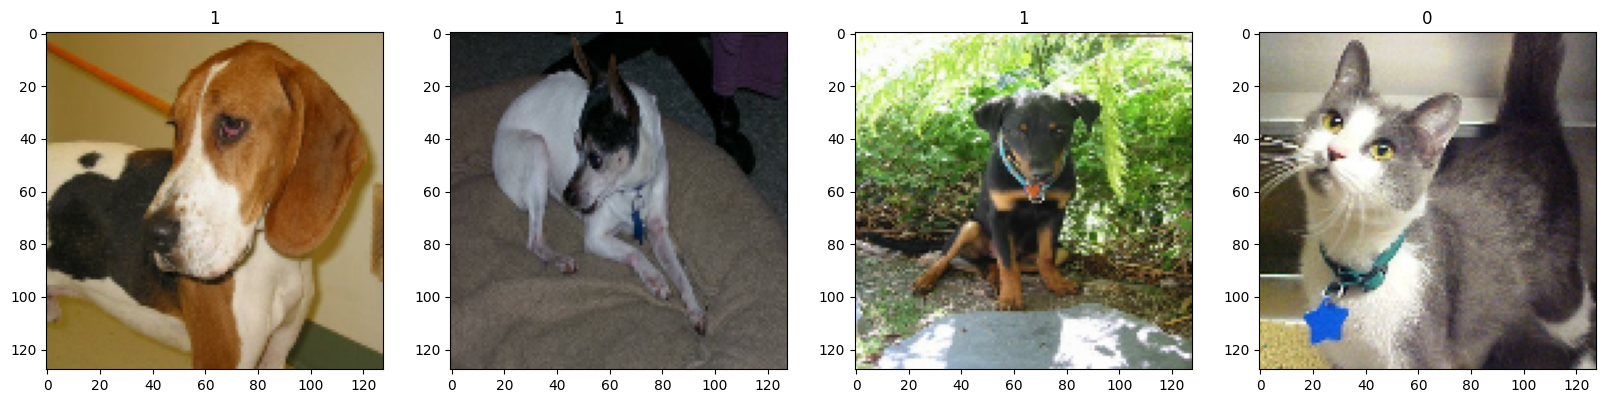

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(
    "/Users/r1/Documents/Projets_python/IA/Cat_Dog_Binary_Classification/Dataset",
    image_size=(128, 128),  
    batch_size=32
).map(lambda x, y: (tf.image.resize(x, (128, 128)), y))

scaled_data=data.map(lambda x,y:(x/255.0,y))
scaled_iterator=scaled_data.as_numpy_iterator()
batch=scaled_iterator.next()

# Plot the first 4 images in the batch along with their labels
fig,ax=plt.subplots(ncols=4, figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])   

#Cat = 0, Dog = 1

### 4. Split the dataset


In [44]:
print(len(data))

# Calculate dataset splits: 70% for training, 20% for validation, 10% for testing
train_size=(int(len(data)*0.7))
val_size=int(len(data)*0.2)+1
test_size=int(len(data)*0.1)+1
print(train_size+val_size+test_size)

# Split the data
train=data.take(train_size)
test=data.skip(train_size).take(test_size)
val=data.skip(train_size+test_size).take(val_size)

624
624


### 5. Model creation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential()

# Add the first convolutional layer
# - 16 filters, kernel size of 3x3
# - Activation function: ReLU
# - L2 regularization to prevent overfitting
# - Input shape: 128x128x3 (image size and 3 color channels)
model.add(Conv2D(16, (3, 3), 1, activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)))

# Add Batch Normalization to stabilize and speed up training
model.add(BatchNormalization())

# Add MaxPooling layer to reduce spatial dimensions while keeping the most important features
model.add(MaxPooling2D())

# Add Dropout layer to randomly deactivate 30% of neurons, helping prevent overfitting
model.add(Dropout(0.3))

# Add the second convolutional layer
# - 32 filters, kernel size of 3x3
# - ReLU activation function
# - L2 regularization
model.add(Conv2D(32, (3, 3), 1, activation='relu', kernel_regularizer=l2(0.001)))

# Add Batch Normalization
model.add(BatchNormalization())

# Add MaxPooling layer
model.add(MaxPooling2D())

# Add Dropout layer to deactivate 40% of neurons
model.add(Dropout(0.4))

# Add the third convolutional layer
# - 64 filters, kernel size of 3x3
# - ReLU activation function
# - L2 regularization
model.add(Conv2D(64, (3, 3), 1, activation='relu', kernel_regularizer=l2(0.001)))

# Add Batch Normalization
model.add(BatchNormalization())

# Add MaxPooling layer
model.add(MaxPooling2D())

# Add Dropout layer to deactivate 50% of neurons
model.add(Dropout(0.5))

# Flatten the output of the previous layers to create a single vector for the dense layers
model.add(Flatten())

# Add a fully connected dense layer
# - 128 neurons
# - ReLU activation function
# - L2 regularization
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))

# Add Dropout layer to deactivate 50% of neurons in the dense layer
model.add(Dropout(0.5))

# Add the output layer
# - 1 neuron (binary classification: cat or dog)
# - Sigmoid activation function to output probabilities
model.add(Dense(1, activation='sigmoid'))

# Compile the model
# - Optimizer: Adam (adaptive learning rate)
# - Loss function: Binary Crossentropy (for binary classification)
# - Metric: Accuracy (to track performance during training and testing)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model architecture
model.summary()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 126, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 61, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,629,921 (6.22 MB)

 Trainable params: 1,629,697 (6.22 MB)

 Non-trainable params: 224 (896.00 B)

### 6. Training

In [38]:
logdir="/Users/r1/Documents/Projets_python/IA/Cat_Dog_Binary_Classification/logs"
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist=model.fit(train, validation_data=val, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 67s 149ms/step - accuracy: 0.5663 - loss: 1.3255 - val_accuracy: 0.6465 - val_loss: 1.0446
Epoch 2/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 65s 149ms/step - accuracy: 0.6357 - loss: 0.9511 - val_accuracy: 0.7020 - val_loss: 0.8595
Epoch 3/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 67s 153ms/step - accuracy: 0.6799 - loss: 0.8875 - val_accuracy: 0.6735 - val_loss: 0.9135
Epoch 4/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 68s 155ms/step - accuracy: 0.7130 - loss: 0.8687 - val_accuracy: 0.7278 - val_loss: 0.8470
Epoch 5/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 68s 156ms/step - accuracy: 0.7352 - loss: 0.8349 - val_accuracy: 0.7430 - val_loss: 0.8478
Epoch 6/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 70s 161ms/step - accuracy: 0.7511 - loss: 0.8112 - val_accuracy: 0.7393 - val_loss: 0.8326
Epoch 7/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 69s 159ms/step - accuracy: 0.7694 - loss: 0.8297 - val_accuracy: 0.7673 - val_loss: 0.8300
Epoch 8/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 68s 157ms/step - accuracy: 0.7799 - loss: 0

### 7. Plot Performance

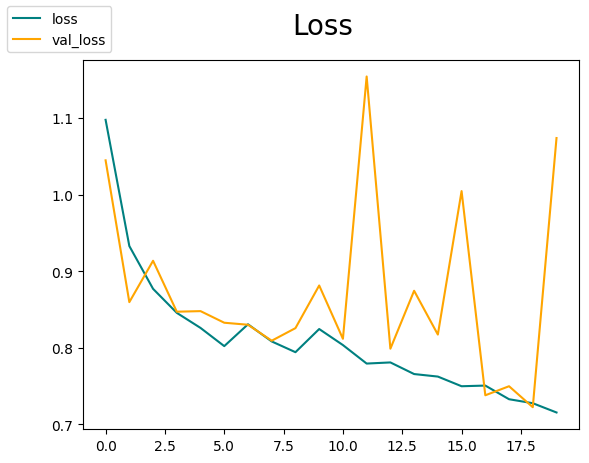

In [39]:
fig=plt.figure()

# Plot the training loss over epochs
# - 'loss' refers to the loss on the training dataset during each epoch
plt.plot(hist.history['loss'],color="teal",label="loss")

# Plot the validation loss over epochs
# - 'val_loss' refers to the loss on the validation dataset during each epoch
plt.plot(hist.history['val_loss'],color="orange",label="val_loss")

fig.suptitle('Loss', fontsize=20)
fig.legend(loc="upper left")
plt.show()

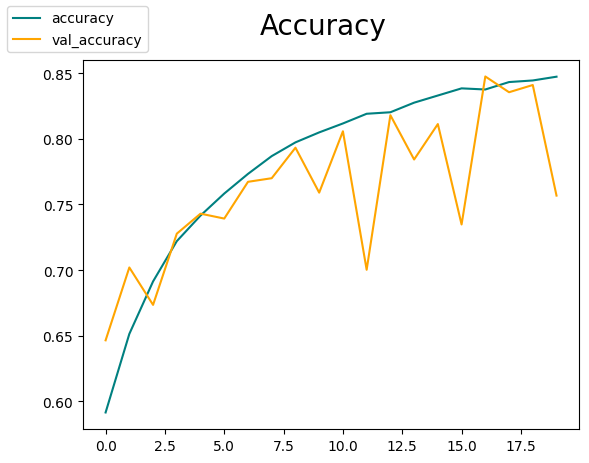

In [ ]:
fig=plt.figure()

# Plot the training accuracy over epochs
# - 'accuracy' refers to the accuracy on the training dataset during each epoch
plt.plot(hist.history['accuracy'],color="teal",label="accuracy")

# Plot the validation accuracy over epochs
# - 'val_accuracy' refers to the accuracy on the validation dataset during each epoch
plt.plot(hist.history['val_accuracy'],color="orange",label="val_accuracy")

fig.suptitle('Accuracy', fontsize=20)
fig.legend(loc="upper left")
plt.show()

### 8. Evaluate Performance

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()  # Measures the proportion of true positive predictions among all positive predictions
re = Recall()  # Measures the proportion of true positives identified out of all actual positives
acc = BinaryAccuracy()  # Measures the overall accuracy of the model for binary classification

for batch in test.as_numpy_iterator(): 
    X, y = batch  # Extract features (X) and true labels (y) from the current batch
    yhat = model.predict(X)  # Predict probabilities for the batch using the trained model

    # Update the precision, recall, and accuracy metrics based on true labels (y) and predictions (yhat)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

# Calculate and print the final results for precision, recall, and accuracy
print(f"Precision : {pre.result().numpy()}, Recall : {re.result().numpy()},  Accuracy: {acc.result().numpy()}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

2025-01-16 20:54:44.331231: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 9. Save the Model

In [42]:
from tensorflow.keras.models import load_model

# Define the path where the model will be saved
model_path = '/Users/r1/Documents/Projets_python/IA/Cat_Dog_Binary_Classification/imageclassifier2.h5'

# Ensure that the directory path exists
# If the directory does not exist, it will be created
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save the trained model 
# This creates a file with the .h5 extension, which contains the model architecture, weights, and training configuration
model.save(model_path)

# Load the saved model 
new_model = load_model(model_path)

### 10. Test the Model with Streamlit Interface

The code for the Streamlit interface, which allows users to upload images and classify them as either a cat or a dog, can be found in the file `app.py`. 

To run the interface, use the following command:

```bash
streamlit run app.py